In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from rlway.osrd.infra import *

In [4]:
infra, sim, res = read_jsons_in_dir('cvg')

In [5]:
routes(infra)

['rt.DA1->DA_out',
 'rt.buffer_stop.0->DA1',
 'rt.DA2->DA_out',
 'rt.buffer_stop.1->DA2',
 'rt.DA_out->DB_in',
 'rt.DB_in->DB2',
 'rt.DB_in->DB1',
 'rt.DB1->buffer_stop.2',
 'rt.DB2->buffer_stop.3']

In [7]:
route_switches(infra)

{'rt.DA1->DA_out': 'CVG',
 'rt.DA2->DA_out': 'CVG',
 'rt.DB_in->DB2': 'DVG',
 'rt.DB_in->DB1': 'DVG'}

In [8]:
route_limits(infra)

{'DA1': ('STA_Q1', 430.0),
 'DA2': ('STA_Q2', 430.0),
 'DA_out': ('T', 50.0),
 'DB_in': ('T', 9970.0),
 'DB1': ('STB_Q1', 30.0),
 'DB2': ('STB_Q2', 30.0),
 'buffer_stop.0': ('STA_Q1', 0.0),
 'buffer_stop.1': ('STA_Q2', 0.0),
 'buffer_stop.2': ('STB_Q1', 450.0),
 'buffer_stop.3': ('STB_Q2', 450.0)}

In [9]:
track_section_lengths(infra)

{'STA_Q1': 450.0,
 'STA_Q2': 450.0,
 'T': 10000.0,
 'STB_Q1': 450.0,
 'STB_Q2': 450.0}

In [10]:
route_lengths(infra)

{'rt.DA1->DA_out': 70.0,
 'rt.buffer_stop.0->DA1': 430.0,
 'rt.DA2->DA_out': 70.0,
 'rt.buffer_stop.1->DA2': 430.0,
 'rt.DA_out->DB_in': 9920.0,
 'rt.DB_in->DB2': 60.0,
 'rt.DB_in->DB1': 60.0,
 'rt.DB1->buffer_stop.2': 420.0,
 'rt.DB2->buffer_stop.3': 420.0}

In [11]:
draw_infra(infra)

# Schedule

In [12]:
from rlway.schedules import Schedule
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def schedule_from_simulation(
        infra: Dict,
        res: List,
        simplify_route_names: bool = False
    ) -> Schedule:

    routes = [route['id'] for route in infra['routes']]

    s = Schedule(len(routes), len(res))

    routes_switches = {
        route['id']:list(route['switches_directions'].keys())[0] 
        for route in infra['routes']
        if len(list(route['switches_directions'].keys()))!=0
    }
    simulations = 'base_simulations'
    simulations = 'eco_simulations'

    for train in range(s.num_trains):
        route_occupancies = res[train][simulations][0]['route_occupancies']
        for route, times in route_occupancies.items():
            idx = routes.index(route)
            s._df.loc[idx, (train, 's')] = times['time_head_occupy']
            s._df.loc[idx, (train, 'e')] = times['time_tail_free']
    s._df.index = routes

    s._df.index = pd.Series(s.df.index.map(routes_switches)).fillna(pd.Series(s.df.index))

    s._df = s.df[~s.df.index.duplicated()] 

    if simplify_route_names:
        s._df.index = (
            s.df.index
            .str.replace('rt.','', regex=False)
            .str.replace('buffer_stop','STOP', regex=False)
        )

    return s


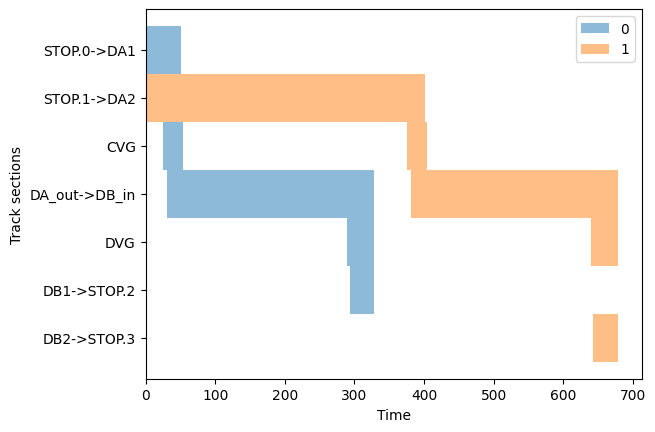

In [15]:
s = schedule_from_simulation(infra, res, simplify_route_names=True)
s.add_delay(1,'STOP.1->DA2', 350).sort().plot()

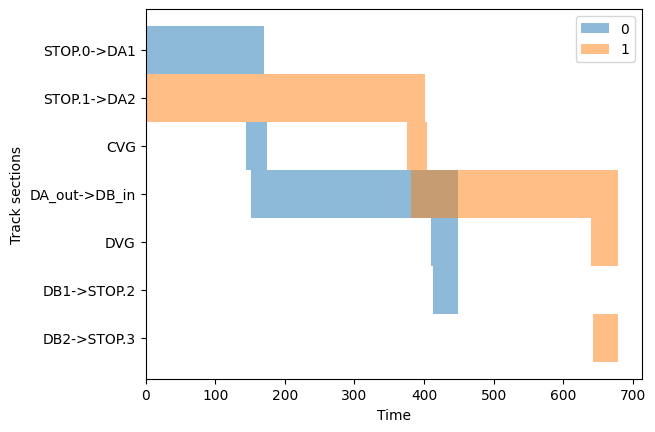

In [16]:
s.add_delay(1,'STOP.1->DA2', 350).add_delay(0,'STOP.0->DA1', 120).sort().plot()

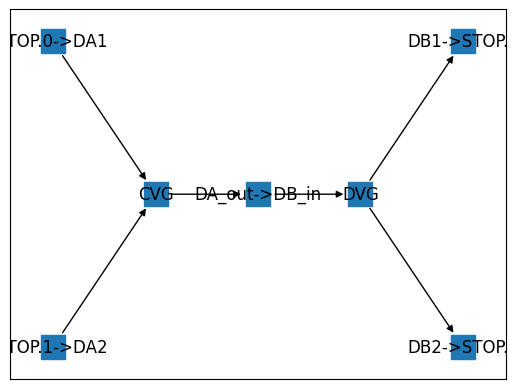

In [17]:
s.draw_graph()

# Regulation environment

In [20]:
from rlway.regul_env0 import RegulEnv

In [21]:
s = s.add_delay(1,'STOP.1->DA2', 350)

In [22]:
env = RegulEnv(s, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

# Use case: 2 trains

In [23]:
from tqdm import tqdm
import numpy as np

total_delay_0 = []
total_delay_1 = []
delays= list(range(60,640,10))
for delay in tqdm(delays):
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(0)
    except:
        reward = np.nan
    total_delay_0.append(-reward)
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(1)
    except:
        reward = np.nan
    total_delay_1.append(-reward)

100%|██████████| 58/58 [02:06<00:00,  2.18s/it]


Text(0, 0.5, '$Q(s,a)$ = Total delay at stations')

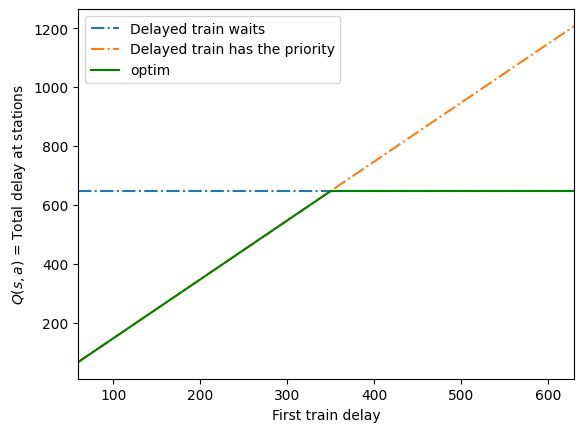

In [25]:
plt.plot(delays, total_delay_0, '-.', label='Delayed train waits')
plt.plot(delays, total_delay_1, '-.',  label='Delayed train has the priority')
plt.plot(delays, np.minimum(total_delay_0, total_delay_1), 'g-',label='optim')
plt.legend()
plt.xlim(60, 630)
plt.xlabel('First train delay')
plt.ylabel('$Q(s,a)$ = Total delay at stations')

In [29]:
total_delay_1[2]

107.56100000000004

In [33]:
delays[0:4], total_delay_1[0:4]

([60, 70, 80, 90],
 [67.56100000000004,
  87.56100000000004,
  107.56100000000004,
  127.56100000000004])

# Résultats du calcul de marche

In [ ]:
base_head_positions = res[0]['base_simulations'][0]['head_positions']
eco_head_positions = res[0]['eco_simulations'][0]['head_positions']

t_base = [dict['time'] for dict in base_head_positions]
y_base = [dict['path_offset'] for dict in base_head_positions]
t_eco = [dict['time'] for dict in eco_head_positions]
y_eco = [dict['path_offset'] for dict in eco_head_positions]
plt.plot(t_base, y_base, label='base')
plt.plot(t_eco, y_eco, label='eco')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')

In [ ]:
base_speeds = res[0]['base_simulations'][0]['speeds']
eco_speeds = res[0]['eco_simulations'][0]['speeds']
t__base = [dict['time'] for dict in base_speeds]
y__base = [dict['speed'] for dict in base_speeds]
t__eco = [dict['time'] for dict in eco_speeds]
y__eco = [dict['speed'] for dict in eco_speeds]
plt.plot(t__base, y__base, label='base')
plt.plot(t__eco, y__eco, label='eco')
plt.legend()
plt.xlabel('Time')
plt.ylabel('speed')

In [ ]:
import datetime
str(datetime.timedelta(seconds=320))

https://stackoverflow.com/questions/48294332/plot-datetime-timedelta-using-matplotlib-and-python

In [ ]:
G = env.schedule.graph

In [ ]:
for r in routes(infra):
    print(r)